<a href="https://colab.research.google.com/github/pritkudale/Code_for_LinkedIn/blob/main/K_fold_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

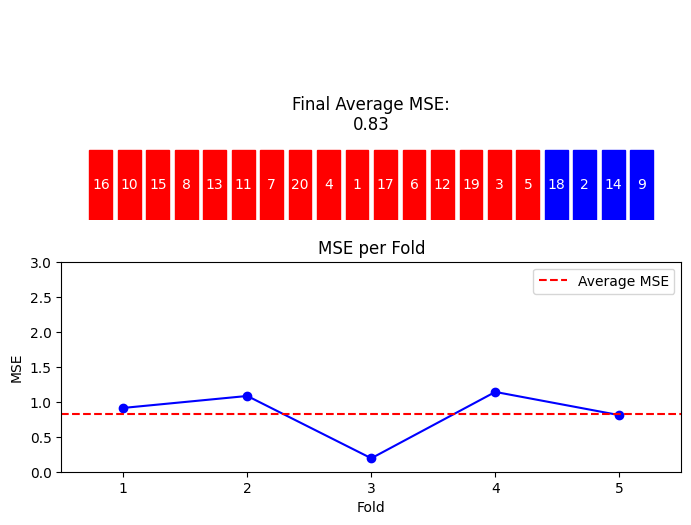

MSE scores for each fold: [0.9113650131282257, 1.0822885170459626, 0.1919190679512955, 1.1399965260480642, 0.8083640525131215]
Final average MSE: 0.8267866353373339


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate synthetic data
X = np.arange(1, 21).reshape(-1, 1)
y = 2 * X.flatten() + np.random.normal(0, 1, size=20)

# Shuffle the data only once
rng = np.random.default_rng(42)
shuffled_indices = rng.permutation(len(X))
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

# K-fold cross-validation without shuffling again
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)

# Figure setup
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
bar_width = 0.8
bars = ax1.bar(range(1, len(X_shuffled) + 1), np.ones_like(X_shuffled.flatten()), color="red", edgecolor="black", width=bar_width)
ax1.set_ylim(0, 3)
ax1.axis("off")

# Text and number labels, centered
info_text = ax1.text(10.5, 1.5, "", fontsize=12, ha="center", va="center")
score_texts = []
number_texts = []

# Display shuffled indices on the bars
for i, bar in enumerate(bars):
    number_text = ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, str(i + 1),
                           ha="center", va="center", fontsize=10, color="white")
    number_texts.append(number_text)

# Line plot setup
x_mse = np.arange(1, n_splits + 1)
line, = ax2.plot([], [], marker='o', linestyle='-', color='blue')
ax2.set_xlim(0.5, n_splits + 0.5)
ax2.set_ylim(0, 3)
ax2.set_xlabel("Fold")
ax2.set_ylabel("MSE")
ax2.set_title("MSE per Fold")

# Average MSE line
avg_mse_line, = ax2.plot([], [], linestyle='--', color='red', label='Average MSE')

# Initialize score list
scores = []

def update(frame):
    for score_text in score_texts:
        score_text.set_visible(False)

    if frame == 0: # Initial frame: Show original data
        info_text.set_text("Original Data")
        for i, bar in enumerate(bars):
          number_texts[i].set_text(str(i+1))

    elif frame == 1: # Second frame : Show shuffled data
        info_text.set_text("Shuffled Data")
        for i, (number_text, bar) in enumerate(zip(number_texts, bars)):
            number_text.set_text(str(shuffled_indices[i] + 1)) # Update with shuffled index

    elif frame < len(frames) + 2: # Actual K-fold animation frames
        for bar in bars:
            bar.set_color("red")
        test_indices = frames[frame - 2]["test"]
        train_indices = frames[frame - 2]["train"]
        for i in test_indices:
            bars[i].set_color("blue")

        model = LinearRegression()
        model.fit(X_shuffled[train_indices], y_shuffled[train_indices])
        y_pred = model.predict(X_shuffled[test_indices])
        mse = mean_squared_error(y_shuffled[test_indices], y_pred)

        if len(scores) <= frame - 2:
            scores.append(mse)

        info_text.set_text(f"Fold {frames[frame - 2]['fold']}\nTest Index: {test_indices + 1}\nMSE: {mse:.2f}")
        y_offset = -0.3
        for idx, score in enumerate(scores):
            score_text = ax1.text(idx + 1, y_offset, f"{score:.2f}", fontsize=8, ha="center", color="black")
            score_texts.append(score_text)
        line.set_data(x_mse[:len(scores)], scores)

    else: # Final frame
        avg_mse = np.mean(scores)
        info_text.set_text(f"Final Average MSE:\n{avg_mse:.2f}")

        line.set_data(x_mse, scores + [0]*(len(x_mse) - len(scores)))
        avg_mse_line.set_data(ax2.get_xlim(), [avg_mse, avg_mse])

# Animation setup
frames = []
fold = 1
for train_idx, test_idx in kf.split(X_shuffled):
    frames.append({"fold": fold, "train": train_idx, "test": test_idx})
    fold += 1

ani = FuncAnimation(fig, update, frames=range(len(frames) + 3), repeat=False, interval = 1000)
ax2.legend()

ani.save("kfold_cv.gif", writer="pillow", fps=1)
plt.show()

print("MSE scores for each fold:", scores)
print("Final average MSE:", np.mean(scores))